# Image Processing SoSe 2024 - Assignment - 10

### Deadline is 04.07.2024 at 12:00 p.m.

#### Students: Minh Tuan Nguyen, Vinzent Hannes Jörß

Please solve the assignments together with a partner.

Make sure the code runs without errors, when clicking `Kernel` -> `Restart Kernel & Run All Cells`. Then save the notebook and upload your submission.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.linalg
from skimage.color import rgb2gray
from skimage.data import chelsea
from scipy.fftpack import dctn, idctn

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - Hadamard Matrix - 4 Points

Create a [hadamard matrix](https://en.wikipedia.org/wiki/Hadamard_matrix) of order n and apply it to the chessboard.

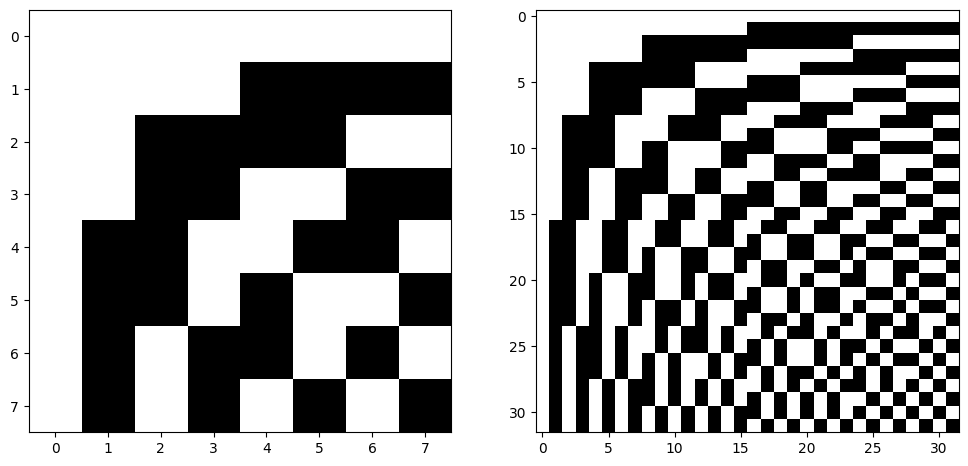

In [3]:
A = np.array([[1, 1],
              [1,-1]]) / np.sqrt(2)

def hadamard_matrix(n, order='normal'):
    """Returns the Hadamard matrix. N is a power of two.
    
    order - can be 'normal' or 'sequency'."""
    if n == 1:
        return np.array([[1.]])
    assert n % 2 == 0, "N is not a power of two"

    h = np.kron(A, hadamard_matrix(n >> 1))

    if order == 'sequency':
        # count sign changes and reorder
        order = np.count_nonzero(h[:,:-1] != h[:,1:], axis=-1)
        h[order] = np.copy(h)

    return h

plt.subplot(121)
plt.imshow(hadamard_matrix(8, 'sequency'), cmap='gray')
plt.subplot(122)
plt.imshow(hadamard_matrix(32, 'sequency'), cmap='gray')
plt.show()

In [4]:
def get_chess_board(n=8, field_size=8):
    board = np.zeros((n*field_size, n*field_size))
    s = field_size
    for i in range(n):
        for j in range(n):
            if (i + j) % 2 == 0:
                board[i*s:(i+1)*s, j*s:(j+1)*s] = 1
    return board

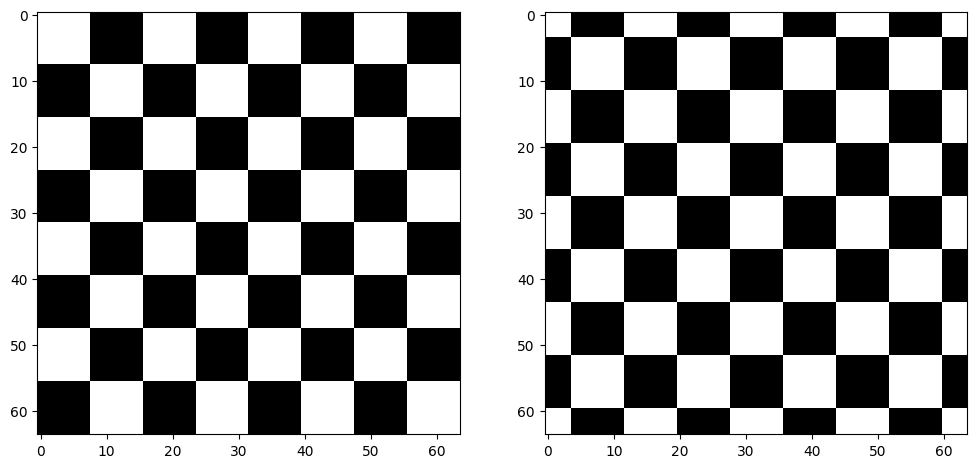

In [5]:
chess_board = get_chess_board()
chess_board_roll = np.roll(np.roll(chess_board, 4, axis=0), 4, axis=1)
plt.subplot(121)
plt.imshow(chess_board, cmap='gray', interpolation='nearest')
plt.subplot(122)
plt.imshow(chess_board_roll, cmap='gray', interpolation='nearest')
plt.show()

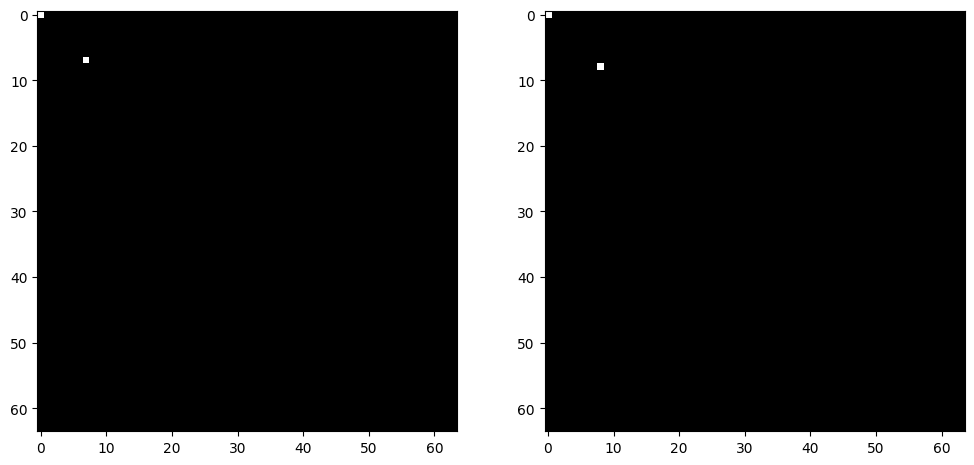

In [6]:
# Plot the 2d hadamard transformation of the chess boards.
# The 2D Hadamard Transformation can be computed similar to the 2D DFT:
# H * I * H, where I is the image, H is the hadamard-matrix and * is the matrix multiplication.

H = hadamard_matrix(64, 'sequency')

chess_board_H = H @ chess_board @ H
chess_board_roll_H = H @ chess_board_roll @ H

plt.subplot(221)
plt.imshow(chess_board_H, cmap='gray', interpolation='nearest')
plt.subplot(222)
plt.imshow(chess_board_roll_H, cmap='gray', interpolation='nearest')
plt.show()

# Exercise 2 - Compare DCT with Discrete Hadamard transform and Haar transform - 6 Points

Transform the cat image with DCT, WHT (Walsh Hadamard Transformation) and Haar transform.
Erase **75 percent** of coefficients. For DCT you can set the last 75% of the ZigZag Ordering to 0. For Hadamard transform you have to bring the matrices into [sequence ordering](https://en.wikiversity.org/wiki/Walsh_permutation;_sequency_ordered_Walsh_matrix) first and then erase from the ZigZag Ordering. For Haar transform simply keep the 25% highest coefficients and erase the rest.

Transform back into image space and calculate the average quadratic pixel error w.r.t. the original image.

Plot window size vs DCT, Hadamard transform and Haar transform. Show the MSE error for WindowSizes 8x8, 32x32, 64x64, 128x128 and 256x256
for DCT and DWalHadT, DWalHT respectively.

In [7]:
class Blocks:
    """Transforms an image to blocks. A (512, 512) image will become an (64, 64, 8, 8) numpy array"""
    def __init__(self, block_size=8):
        self.block_size = block_size

    def __call__(self, img):
        b = self.block_size
        height, width = img.shape

        assert img.shape[0] % b == 0
        assert img.shape[1] % b == 0
        blocks = np.zeros((height // b, width // b, b, b), dtype=img.dtype)
        for i in range(0, height // b):
            for j in range(0, width // b):
                blocks[i, j] = img[i*b:(i+1)*b, j*b:(j+1)*b]
        return blocks
    def invert(self, blocks):
        bh, bw = blocks.shape[:2]
        b = self.block_size
        heigth, width = (bh*self.block_size, bw*self.block_size)

        img = np.zeros((heigth, width), dtype=blocks.dtype)
        for i in range(0, bh):
            for j in range(0, bw):
                img[i*b:(i+1)*b, j*b:(j+1)*b] = blocks[i, j]
        return img

In [8]:
class DCTofBlocks:
    def __call__(self, blocks):
        """Returns the DCT of the blocks. The position (i, j) is a 2-dim numpy array with the dct coefficients."""
        result = np.zeros_like(blocks)
        for row in range(0, blocks.shape[0]):
            for column in range(0, blocks.shape[1]):
                result[row][column] = dctn(blocks[row][column], norm='ortho')
        return result

    def invert(self, blocks):
        """Computes the inverse DCT."""
        result = np.zeros_like(blocks)
        for row in range(0, blocks.shape[0]):
            for column in range(0, blocks.shape[1]):
                result[row][column] = idctn(blocks[row][column], norm='ortho')

        return result

In [9]:
class HadamardofBlocksSequenceOrdering:
    def __call__(self, blocks):
        """Returns the Hardamard transform of the blocks. The position (i, j) is a 2-dim numpy array with the hadamard transform coefficients."""
        h = hadamard_matrix(blocks.shape[3], 'sequency')
        blocks = h @ blocks @ h
        return blocks

    def invert(self, blocks):
        """Computes the inverse hadamard transform."""
        h = hadamard_matrix(blocks.shape[3], 'sequency')
        blocks = h @ blocks @ h
        return blocks

In [10]:
def haar_matrix(n):
    if n == 1:
        return np.array([[1.]])
    assert n % 2 == 0, "N is not a power of two."

    h = haar_matrix(n >> 1)
    i = np.eye(n >> 1)
    h = np.block([
        [np.kron(h, [1, 1]) / np.sqrt(2)],
        [np.kron(i, [1,-1]) / np.sqrt(2)]])
    return h

class HaarTransformofBlocks:
    def __call__(self, blocks):
        """Returns the haar transform of the blocks. The position (i, j) is a 2-dim numpy array with the haar transform coefficients."""
        h = haar_matrix(blocks.shape[3])
        blocks = h @ blocks @ h.T
        return blocks

    def invert(self, blocks):
        """Computes the inverse haar transform."""
        h = haar_matrix(blocks.shape[3])
        blocks = h.T @ blocks @ h
        return blocks

In [11]:
class ZigZag:
    def __init__(self, n):
        self.n = n
        """Adapted from here: https://rosettacode.org/wiki/Zig-zag_matrix#Python"""
        def key(pair):
            x, y = pair
            return x+y, -y if (x+y) % 2 else y

        indexorder = sorted(((x,y) for x in range(n) for y in range(n)), key=key)
        self.xs = np.zeros((self.n**2,), dtype=int)
        self.ys = np.zeros((self.n**2,), dtype=int)
        self.back = np.zeros((n, n), dtype=int)
        for i, (x, y) in enumerate(indexorder):
            self.xs[i] = x
            self.ys[i] = y
            self.back[x, y] = i

    def __call__(self, blocks):
        bh, bw, h, w = blocks.shape
        zigzack_blocks = np.zeros((bh, bw, h*w), dtype=blocks.dtype)
        for i, block_row in enumerate(blocks):
            for j, block in enumerate(block_row):
                zigzack_blocks[i, j] = block[self.xs, self.ys]
        return zigzack_blocks

    def invert(self, zigzack_blocks):
        bh, bw, hw = zigzack_blocks.shape
        h = int(np.sqrt(hw))
        blocks = np.zeros((bh, bw, h, h), dtype=zigzack_blocks.dtype)
        for i, zigzack_row in enumerate(zigzack_blocks):
            for j, zigzack in enumerate(zigzack_row):
                blocks[i, j] = zigzack[self.back]
        return blocks

In [12]:
class PickNZigZag:
    def __init__(self, n=1):
        self.n = n

    def __call__(self, blocks):
        """Pick the nth-first frequencies from zigzag ordering"""
        result = ZigZag(blocks.shape[3])(blocks.copy())
        for row in range(0, blocks.shape[0]):
            for column in range(0, blocks.shape[1]):
                zig = result[row, column]
                zig[self.n:] = 0
                result[row, column] = zig
        return ZigZag(blocks.shape[3]).invert(result)

    def invert(self, blocks):
        """There is no way to invert this operation. Just return the inputs."""
        return blocks

In [13]:
class PickNthHighest:
    def __init__(self, n=1):
        self.n = n

    def __call__(self, blocks):
        """Pick the nth-highest frequencies"""
        for row in range(0, blocks.shape[0]):
            for column in range(0, blocks.shape[1]):
                block = blocks[row, column].flatten()
                block[np.argpartition(block, len(block) - self.n)[:-self.n]] = 0
                blocks[row, column] = block.reshape(blocks.shape[2], blocks.shape[3])
        return blocks

    def invert(self, blocks):
        """There is no way to invert this operation. Just return the inputs."""
        return blocks

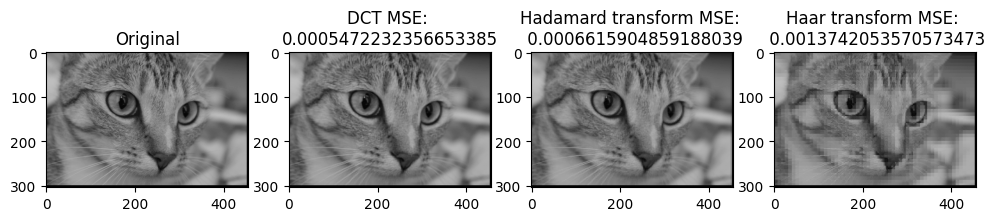

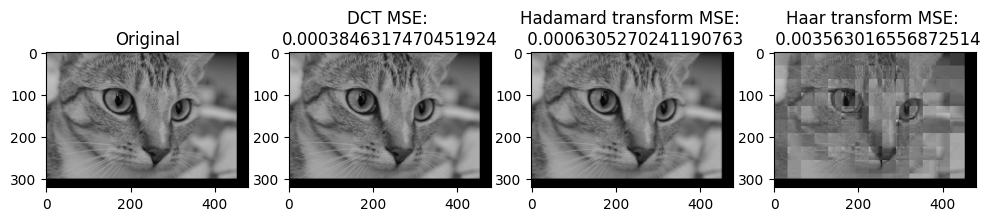

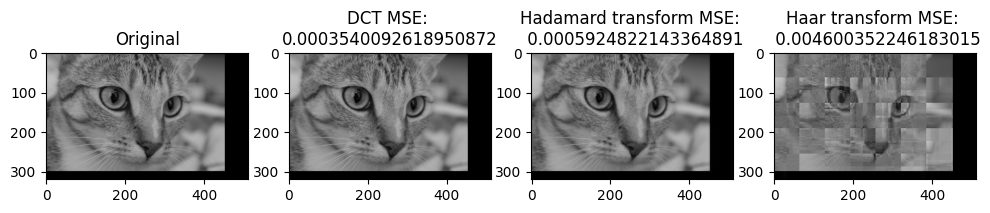

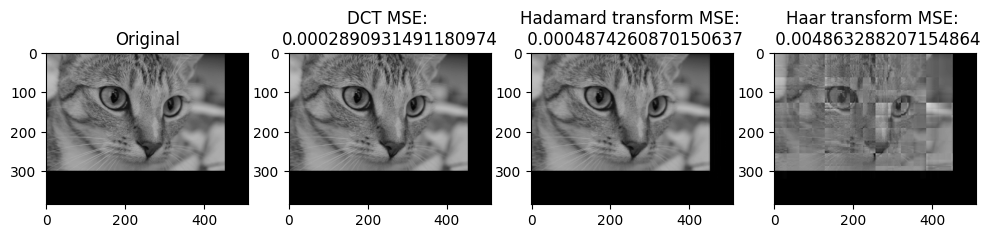

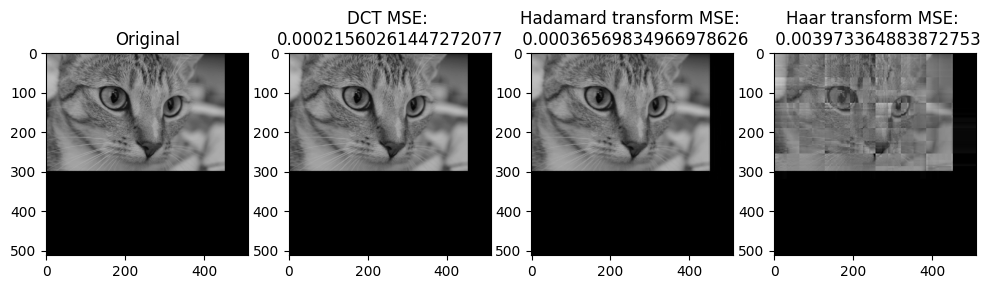

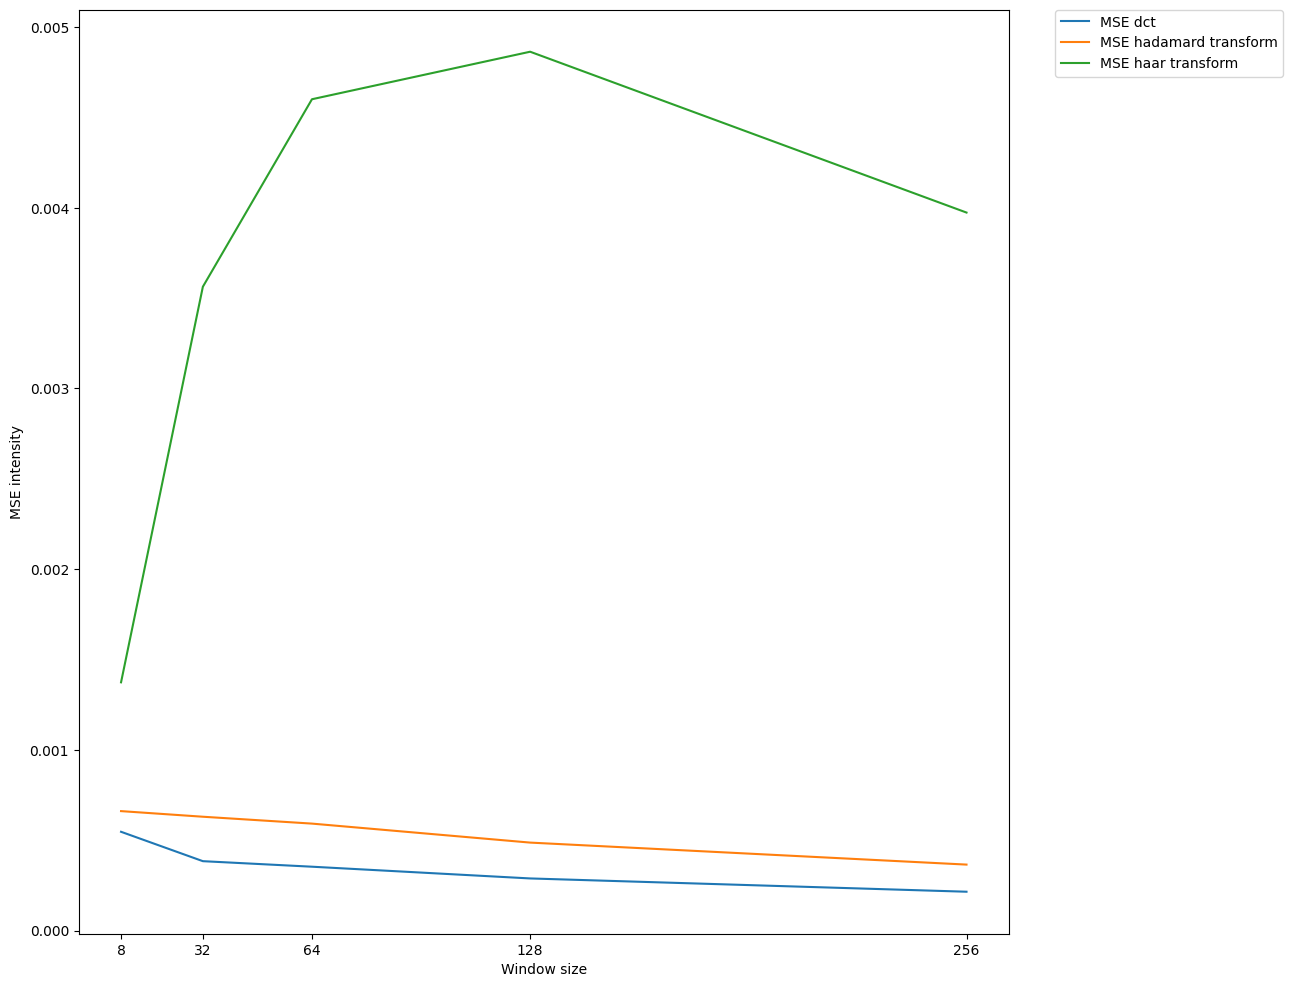

In [14]:
img = rgb2gray(chelsea())
sizes = [8, 32, 64, 128, 256]
mse_dct_arr = []
mse_hadamard_arr = []
mse_haar_arr = []
for size in sizes:
    # pad image for blocking
    pad_x = 0 if img.shape[0] % size == 0 else (img.shape[0] // size + 1) * size - img.shape[0]
    pad_y = 0 if img.shape[1] % size == 0 else (img.shape[1] // size + 1) * size - img.shape[1]
    img_pad = np.pad(img, ((0, pad_x), (0, pad_y)))

    blocks = Blocks(block_size=size)(img_pad)
    dct_blocks = DCTofBlocks()(blocks.copy())
    hadamard_blocks = HadamardofBlocksSequenceOrdering()(blocks.copy())
    haar_blocks = HaarTransformofBlocks()(blocks.copy())

    dct_highest = PickNZigZag(size ** 2 // 4)(dct_blocks)
    hadamard_highest = PickNZigZag(size ** 2 // 4)(hadamard_blocks)
    haar_highest = PickNthHighest(size ** 2 // 4)(haar_blocks)

    dct_img = Blocks(block_size=size).invert(DCTofBlocks().invert(dct_highest))
    hadamard_img = Blocks(block_size=size).invert(HadamardofBlocksSequenceOrdering().invert(hadamard_highest))
    haar_img = Blocks(block_size=size).invert(HaarTransformofBlocks().invert(haar_highest))

    mse_dct = ((img_pad - dct_img)**2.0).mean(axis=None)
    mse_hadamard = ((img_pad - hadamard_img)**2.0).mean(axis=None)
    mse_haar = ((img_pad - haar_img)**2.0).mean(axis=None)

    mse_dct_arr.append(mse_dct)
    mse_hadamard_arr.append(mse_hadamard)
    mse_haar_arr.append(mse_haar)

    plt.subplot(141)
    plt.title("Original")
    plt.imshow(img_pad, cmap='gray', vmin=0, vmax=1)
    plt.subplot(142)
    plt.title("DCT MSE: \n" + str(mse_dct))
    plt.imshow(dct_img, cmap='gray', vmin=0, vmax=1)
    plt.subplot(143)
    plt.title("Hadamard transform MSE: \n " + str(mse_hadamard))
    plt.imshow(hadamard_img, cmap='gray', vmin=0, vmax=1)
    plt.subplot(144)
    plt.title("Haar transform MSE: \n " + str(mse_haar))
    plt.imshow(haar_img, cmap='gray', vmin=0, vmax=1)
    plt.show()

plt.plot(sizes, mse_dct_arr, label="MSE dct")
plt.plot(sizes, mse_hadamard_arr, label="MSE hadamard transform")
plt.plot(sizes, mse_haar_arr, label="MSE haar transform")
plt.ylabel("MSE intensity")
plt.xlabel("Window size")
plt.xticks(sizes)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()